/shared-libs/python3.8/py/lib/python3.8/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.17.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
********** Obstacle Field: 0 **********
Potential Path Time: 0.6611225410597399
Diff Flat Time: 0.0014998889528214931
0.7804632134199622
Potential Path Valid: True


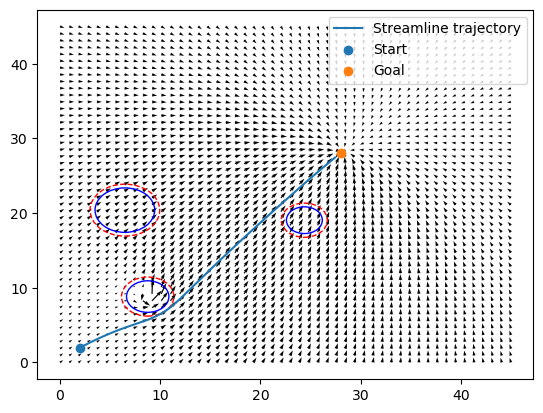

  cost: 167530.02684631705
  cost: 167693.3450745224
  cost: 167626.34761476133
  cost: 167559.4470451076
  cost: 167492.643313294
  cost: 167425.93636637038
  cost: 167359.32615069285
  cost: 167292.81261191942
  cost: 167226.39569500263
  cost: 167160.0753441837
  cost: 167093.8515029805
  cost: 167027.72411418497
  cost: 166961.69311985065
  cost: 166895.75846128713
  cost: 166829.92007904974
  cost: 166764.17791292985
  cost: 166698.53190194734
  cost: 166632.98198433968
  cost: 166567.5280975527
  cost: 166502.17017822945
  cost: 166436.90816220109
  cost: 166371.741984477
  cost: 166306.6715792307
  cost: 166241.69687979214
  cost: 166176.81781863532
  cost: 166112.0343273669
  cost: 166047.3463367131
  cost: 165982.75377651045
  cost: 165918.2565756923
  cost: 165853.85466227634
  cost: 165789.54796335386
  cost: 165725.33640507326
  cost: 165661.21991263368
  cost: 165597.19841026564
  cost: 165533.27182122305
  cost: 165469.44006776708
  cost: 165405.70307115433
  cost: 165342

KeyboardInterrupt: 

In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from timeit import default_timer as timer

import potential_field_path as pf
importlib.reload(pf)
from create_obst_field import create_obst_field, recreate_obst_field
from diff_flat import diff_flat
from quad_sim import simulate_traj

import iLQR
importlib.reload(iLQR)
from iLQR import iLQR

test_results = {}

start = np.array([2,2])
goal = np.array([28,28])

safe_factor = 0.5
x = np.linspace(0,45, 50, dtype=np.float)
y = np.linspace(0,45, 50, dtype=np.float)
XX, YY = np.meshgrid(x,y)

for i in range(1):
    print(f'********** Obstacle Field: {i} **********')
    obst_field, obst_seeds = create_obst_field(num_obst=3, xlim=(5.5, 24.5), ylim=(5.5, 24.5), rlim=(0.5,3))

    # Time potential path
    start_time = timer()
    xs, ys, U, V, tf = pf.potential_path(XX, YY, start, goal, obst_field, safe_factor)
    end_time = timer()
    time_potential = timer() - start_time # time in sec
    print(f'Potential Path Time: {time_potential}')

    # Time diff_flatness 
    start_time = timer()
    z, u = diff_flat(xs, ys, tf)
    time_diff_flat = timer() - start_time # time in sec
    print(f'Diff Flat Time: {time_diff_flat}')

    # Ignore time of simulate_traj, just meant for debugging
    dt = tf/np.shape(u)[1]
    #z_traj = simulate_traj(z[:,0], u, dt)
    dist_goal = np.sqrt((z[0,-1] - goal[0])**2 + (z[1,-1]-goal[1])**2)
    print(dist_goal)
    # Check feasibility
    potential_path_valid = True;
    if  dist_goal > 2:
        potential_path_valid = False;
    else: 
        for obst in obst_field:
            is_collide, _, _ = pf.detect_collision(z[0,:], z[1,:], obst, 0)
            if is_collide:
                potential_path_valid = False;
                break
    print(f'Potential Path Valid: {potential_path_valid}')

    # plot potential path
    fig, axs = plt.subplots()
    for obstacles in obst_field:
        xc, yc, r = obstacles
        draw_obst = plt.Circle((xc, yc), r, color='b', fill=False, label="Obstacle")
        axs.add_artist(draw_obst)
        draw_obst = plt.Circle((xc, yc), safe_factor + r, linestyle='dashed', color='r', fill=False, label="Saftey zone")
        axs.add_artist(draw_obst)
    axs.quiver(XX,YY,U,V)
    axs.scatter(start[0], start[1], label="Start")
    axs.scatter(goal[0], goal[1], label="Goal")
    # axs.streamplot(XX,YY,U,V,start_points=[start], integration_direction='forward')
    axs.plot(z[0,:], z[1,:], label="Streamline trajectory")
    #axs.plot(z_traj[:,0], z_traj[:,1], label="Differentially flat recreated trajectory")
    plt.legend()
    plt.show()

    # ********** iLQR **********
    # Setup the iLQR problem
    N = np.shape(u)[1] + 1
    dt = dt
    x_goal = np.hstack((goal, [0,0,0,0]));

    # TODO: Adjust the costs as needed for convergence
    Q = np.eye(6)
    Qf = 1e2 * np.eye(6)
    R = 1e-2 * np.eye(2)

    #***** Time iLQR warmstart *****
    z_warm = z
    u_warm = u

    start_time = timer()
    ilqr = iLQR(x_goal, N, dt, Q, R, Qf, obst_field)

    try:
        x_sol_warm, u_sol_warm, K_sol_warm, cost_warm = ilqr.calculate_optimal_trajectory(z_warm.T, u_warm.T)
        time_iLQR_warm = timer() - start_time # time in sec
        iLQR_warm_valid = True;
        xx = np.array(x_sol_warm)
        dist_goal = np.sqrt((xx[-1,0] - goal[0])**2 + (xx[-1,1]-goal[1])**2)
        if  dist_goal > 1:
            iLQR_warm_valid = False;
        else: 
            for obst in obst_field:
                is_collide, _, _ = pf.detect_collision(xx[:,0], xx[:,1], obst, 0)
                if is_collide:
                    iLQR_warm_valid = False;
                    break
    except (RuntimeError, np.linalg.LinAlgError):
        iLQR_warm_valid = False;
        time_iLQR_warm = timer() - start_time # time in sec
        x_sol_warm = np.array([0,0,0,0,0,0]).T
        cost_warm = 0
        
    print(f'iLQR Warm Time: {time_iLQR_warm}')
    print(f'iLQR Warm Valid: {iLQR_warm_valid}')
    
    # ***** Time iLQR coldstart *****
    start_time = timer()
    ilqr = iLQR(x_goal, N, dt, Q, R, Qf, obst_field)

    x0 = np.hstack((start, [0,0,0,0]));
    z_cold = np.linspace(x0, x_goal, N).T
    u_cold = np.ones((2,N-1)) * 9.81/2

    try:
        x_sol_cold, u_sol_cold, K_sol_cold, cost_cold = ilqr.calculate_optimal_trajectory(z_cold.T, u_cold.T)
        time_iLQR_cold = timer() - start_time # time in sec
        iLQR_cold_valid = True;
        xx = np.array(x_sol_cold)
        dist_goal = np.sqrt((xx[-1,0] - goal[0])**2 + (xx[-1,1]-goal[1])**2)
        if  dist_goal > 1:
            iLQR_cold_valid = False;
        else: 
            for obst in obst_field:
                is_collide, _, _ = pf.detect_collision(xx[:,0], xx[:,1], obst, 0)
                if is_collide:
                    iLQR_cold_valid = False;
                    break
    except (RuntimeError, np.linalg.LinAlgError):
        iLQR_cold_valid = False;
        time_iLQR_cold = timer() - start_time # time in sec
        x_sol_cold = np.array([0,0,0,0,0,0]).T
        cost_cold = 0

    print(f'iLQR Cold Time: {time_iLQR_cold}')
    print(f'iLQR Cold Valid: {iLQR_cold_valid}')

    ## dictionary logging
    test_results[i] = {"obst_field" : obst_field,
                    "time_potential" : time_potential,
                    "potential_path_valid" : potential_path_valid,
                    "potential_path_x" : xs,
                    "potential_path_y" : ys,
                    "time_diff_flat" : time_diff_flat,
                    "time_iLQR_cold" : time_iLQR_cold,
                    "iLQR_cold_valid" : iLQR_cold_valid,
                    "iLQR_cold_path" : x_sol_cold,
                    "cost_iLQR_cold" : cost_cold,
                    "time_iLQR_warm" : time_iLQR_warm,
                    "iLQR_warm_valid" : iLQR_warm_valid,
                    "iLQR_warm_path" : x_sol_warm,
                    "cost_iLQR_warm" : cost_warm}

np.save("test_results.npy", test_results)

In [2]:
import numpy as np

results = np.load("test_results.npy", allow_pickle='TRUE')
results = results.item()    # thhis is how you have to unpack the dict when using np.save()

time_warm = np.zeros(len(results))
time_cold = np.zeros(len(results))
cost_warm = np.zeros(len(results))
cost_cold = np.zeros(len(results))
valid_warm = np.zeros(len(results), dtype=bool)
valid_cold = np.zeros(len(results), dtype=bool)

for i in range(len(results)):
    time_warm[i] = results[i]["time_potential"] + results[i]["time_diff_flat"] + results[i]["time_iLQR_warm"]
    time_cold[i] = results[i]["time_iLQR_cold"]

    cost_warm[i] = results[i]["cost_iLQR_warm"]
    cost_cold[i] = results[i]["cost_iLQR_cold"]

    valid_warm[i] = results[i]["iLQR_warm_valid"]
    valid_cold[i] = results[i]["iLQR_cold_valid"]

avg_time_warm = np.mean(time_warm[valid_warm])
avg_time_cold = np.mean(time_cold[valid_cold])
avg_cost_warm = np.mean(cost_warm[valid_warm])
avg_cost_cold = np.mean(cost_cold[valid_cold])
success_rate_warm = np.mean(valid_warm)
success_rate_cold = np.mean(valid_cold)

print(f'iLQR Warm Avg Time: {avg_time_warm}')
print(f'iLQR Warm Avg Cost: {avg_cost_warm}')
print(f'iLQR Warm Success Rate: {success_rate_warm}')
print('******************')
print(f'iLQR Cold Avg Time: {avg_time_cold}')
print(f'iLQR Cold Avg Cost: {avg_cost_cold}')
print(f'iLQR Cold Success Rate: {success_rate_cold}')

iLQR Warm Avg Time: 3.595317371771671
iLQR Warm Avg Cost: 134524.53039027317
iLQR Warm Success Rate: 1.0
******************
iLQR Cold Avg Time: nan
iLQR Cold Avg Cost: nan
iLQR Cold Success Rate: 0.0
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


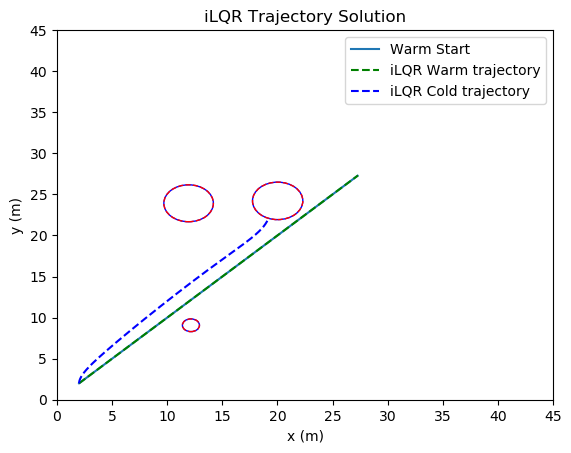

In [3]:
import importlib
import numpy as np
import potential_field_path as pf
importlib.reload(pf)
import matplotlib.pyplot as plt

safe_factor = 0
results = np.load("test_results.npy", allow_pickle='TRUE')
results = results.item()    # thhis is how you have to unpack the dict when using np.save()

for i in range(len(results)):
    test_obst_field = results[i]["obst_field"]
    test_z_warm = results[i]["iLQR_warm_path"]
    test_z_cold = results[i]["iLQR_cold_path"]
    test_xs = results[i]["potential_path_x"]
    test_ys = results[i]["potential_path_y"]
    

    # Visualize the solution
    fig, axs = plt.subplots()
    for obstacles in test_obst_field:
        xc, yc, r = obstacles
        draw_obst = plt.Circle((xc, yc), r, color='b', fill=False, label="Obstacle")
        axs.add_artist(draw_obst)
        draw_obst = plt.Circle((xc, yc), safe_factor + r, linestyle='dashed', color='r', fill=False, label="Saftey zone")
        axs.add_artist(draw_obst)
    axs.plot(test_xs, test_ys, label="Warm Start")

    xx = np.array(test_z_warm)
    axs.plot(xx[:,0], xx[:,1], linestyle='--', color='green', label="iLQR Warm trajectory")
    xx = np.array(test_z_cold)
    axs.plot(xx[:,0], xx[:,1], linestyle='--', color='blue', label="iLQR Cold trajectory")
    plt.title('iLQR Trajectory Solution')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.legend()
    axs.set_xlim(0, 45)
    axs.set_ylim(0, 45)
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5f35f06-accf-4f8f-84f9-e35f4357802a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>